In [7]:
from __future__ import division
import keras
import os
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf


from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model

from keras import optimizers
from keras import initializers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import GRU, RNN, LSTM, Reshape, SimpleRNN, Conv2D, MaxPooling2D, Permute, Flatten, Dense, BatchNormalization, Activation, Dropout

In [8]:
def slice_data(X, V, y, window_size, nr_epochs,step_size):

    sX = [X[:,i*step_size:i*step_size+window_size,:] for i in range(nr_epochs)]
    sV = [V[i*step_size,:] for i in range(nr_epochs)]
    
    sV = np.array(sV)
    sX = np.array(sX)
    sX = np.transpose(sX,(1,2,3,0))
    
    validation = np.zeros((y.shape[0],sV.shape[0]))
    for i in range(y.shape[0]):
        letter_index = y[i,0]-1
        validation[i,:] = sV[:,letter_index] 

    return sX, sV, validation

In [9]:
def transpose_reshape(X,y):
    x_channel, x_window, x_trial, x_epoch = X.shape
    
    X = X.transpose(2,3,1,0)
    X = X.reshape(x_epoch * x_trial, x_window, x_channel, 1)

    y.transpose(1,0)
    y = y.reshape(x_trial * x_epoch)
    
    return X, y

In [10]:
def one_hot_encode(y):
    # One-Hot encoding of a flat validation array
    hot_vector = np.zeros((y.shape[0],2))
    for i in range(y.shape[0]):
        if y[i] == 1:
            hot_vector[i,1] = 1
        else:
            hot_vector[i,0] = 1
            
    return hot_vector   

In [11]:
def load_donders_matfile(par = 1):
    

    
    
    data = loadmat('Data/xsub-{:02d}/xsub-{:02d}_gdf.mat'.format(par,par))
    X = data['X']           # EEG data: channels x samples x trials
    V = data['V']           # Codes: bits x codes
    y = data['y']           # Labels: 1 x trials
    
    
    channels = ['Fpz','T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8']

    print('X: ',X.shape)
    print('V: ',V.shape)
    print('y: ',y.shape)

    n_channels, n_samples, n_trials = X.shape   # Extracting data dimensions
    step_size = 2                               # from 8ms per sample to 16 ms per sample fs/fr
    window_size = 30                            # Number of samples from 120 hz sampling frequency and having 250 ms window.
    nr_epochs = int(n_samples-(n_samples/step_size)-window_size)

    
    # Extend the code to the length of the full trial.
    V_ext = np.tile(V,(15,1))

    sX, sV, validation = slice_data(X,V_ext,y,window_size,nr_epochs,step_size)

    
    
    # Train-test split parameter
    split = int((80/100)*n_trials)
    test_split = int((90/100)*n_trials)
    
    
    sXtrain = sX[:,:,:split,:]
    sXval   = sX[:,:,split:test_split,:] 
    sXtest  = sX[:,:,test_split:,:]
    
    sYtrain = validation[:split,:]
    sYval   = validation[split:test_split,:]
    sYtest  = validation[test_split:,:]
     
    t_train = sXtrain.shape[2]
    e_train = sXtrain.shape[3]
    
    # Transpose and Reshape sXtrain and sXval from (channels x windowSize x trials x epochs) 
    # to (samples x windowSize x channels x 1) such that it fits the NHWC format
    
    sXtrain, sYtrain = transpose_reshape(sXtrain,sYtrain)
    sXval, sYval = transpose_reshape(sXval, sYval)
    sXtest, sYtest = transpose_reshape(sXtest, sYtest)
    
    
    
    
    sYtrain = one_hot_encode(sYtrain)
    sYval = one_hot_encode(sYval)
    sYtest = one_hot_encode(sYtest)
    




    return sXtrain, sYtrain, sXval, sYval, sXtest, sYtest, sV, X, y

x = load_donders_matfile(1)



X:  (8, 3780, 100)
V:  (252, 20)
y:  (100, 1)


In [55]:
def print_learning_history(history, trial=1):
    accuracy = history[0]
    val_accuracy = history[1]
    
    loss = history[2]
    val_loss = history[3]
    
    print('accuracy: ', accuracy)
    print('val_accuracy: ', val_accuracy)
    
    print("\n Participant {:d} \n".format(trial))
    # summarize history for accuracy
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
    plt.rcParams['font.size']=26
    ax1.plot(accuracy)
    ax1.plot(val_accuracy, '--')
    ax1.set_title('CNN accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('iteration')
    plt.rcParams['font.size']=20
    ax1.legend(['train', 'validation'], loc='upper left')
    plt.rcParams['font.size']=26
    ax1.set_ylim([0.5, 1])
    ax1.set_xlim([0, 25])

    ax2.plot(loss)
    ax2.plot(val_loss, '--')
    ax2.set_title('CNN loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('iteration')
    plt.rcParams['font.size']=20
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.rcParams['font.size']=26
    ax2.set_xlim([0, 25])
    
    plt.savefig('NN_training_{:d}.pdf'.format(participant), bbox_inches = 'tight')
    plt.show()

In [14]:
## CREATE EEG2Code CNN Model
def construct_model(windowSize,numberChannels, batchSize):
    model = Sequential()
    model.add(Permute((2,1,3), input_shape=(windowSize,numberChannels,1)))
    # layer1
    model.add(Conv2D(16, kernel_size=(numberChannels, 1), padding='valid', strides=(1, 1), data_format='channels_last', activation='relu'))
    # OG=16
    model.add(BatchNormalization(axis=3, scale=False, center=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2),strides=(1, 1),padding='same')) 
    # layer2
    model.add(Conv2D(8,kernel_size=(1, 12),data_format='channels_last',padding='valid')) #OG = 8, kernel size =(1,64)
    model.add(BatchNormalization(axis=3,scale=False, center=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2),strides=(1, 1),padding='same'))
#     model.add(Dropout(0.5))
    # layer3
    model.add(Conv2D(4,kernel_size=(1,5) ,data_format='channels_last',padding='same')) # ks = (1,5) instead of (5,5) because
    model.add(BatchNormalization(axis=3,scale=False,center=False))                      # our channels are not spatially ordered to be next to each other
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2) , data_format='channels_last',padding='same'))
#     model.add(Dropout(0.5))

    # layer4 (goal: recurrent)
    model.add(Flatten())
    model.add(Dense(256, activation='relu')) #OG = 1024
    model.add(Dropout(0.5))
    
    # layer5
    model.add(Dense(2, activation='softmax'))
    
    return model



# truncated backprop?
# backprop through time?

In [34]:
participant = 1

print('Loading participant: {:d}'.format(participant))
MODEL_FILE = 'basic_trained_{:d}.hdf5'.format(participant)

## PARAMETERS
# initial_learning_rate = 0.003
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=2000,
#     decay_rate=0.96,
#     staircase=True)





## LOAD data
(data_x_train,data_y_train,data_x_val,data_y_val,data_x_test,data_y_test, sV, X, y) = load_donders_matfile(participant)
print(data_x_test.shape)


#Ttrial reduction to 10 s

lr = 0.003                             # the learning rate     OG=0.001, 
batchsize = 1860                       # the batch size        OG=256, 64-32 ideaal?
iterations = 25                            # the number of epochs


Loading participant: 1
X:  (8, 3780, 100)
V:  (252, 20)
y:  (100, 1)
(18600, 30, 8, 1)


In [16]:
# import time


# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = keras.optimizers.Adam(learning_rate=lr)
# train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
# val_acc_metric = keras.metrics.SparseCategoricalAccuracy()


# train_dataset = tf.data.Dataset.from_tensor_slices((data_x_train, data_y_train[:,1]))
# train_dataset = train_dataset.batch(batchsize)

# val_dataset = tf.data.Dataset.from_tensor_slices((data_x_val, data_y_val[:,1]))
# val_dataset = val_dataset.batch(batchsize)


# def rnn_fit(train_dataset, val_dataset, batch_size=batchsize, iterations=iterations):
#     window_size = 30
#     channels = 8
    
    
    
    
#     model = construct_model(data_x_train.shape[1], data_x_train.shape[2], batch_size)
#     accuracy = []
#     loss = []
#     val_accuracy = []
#     val_loss = []
    
#     for iteration in range(iterations):
#         print("\nStart of iteration %d" % (iteration,))
#         start_time = time.time()
        

#         # Iterate over the batches of the dataset. 
#         # Assume batch size = length of trial
#         for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
#             # Reset Recurrent history after each trial
#             # Assume batchsize = trial length
# #             if step % 1860 == 0:
# #                 print('RNN reset')
# #                 model.layers[15].reset_states()
            
# #             # Iterate over epochs within the trial
# #             loss_value = 0
# #             trial_length = x_batch_train.shape[0]
# #             for i in range(0, trial_length):
# #                 x = tf.slice(x_batch_train, begin=[i,0,0,0], size=[1,window_size,channels,1])
# #                 y = tf.slice(y_batch_train, begin=[i], size=[1])

#             with tf.GradientTape() as tape:
#                 logits = model(x_batch_train, training=True)               
#                 loss_value = loss_fn(y_batch_train, logits)

#                 # Learn from loss every 62 samples
# #                 if i%62 == 0:
#             grads = tape.gradient(loss_value, model.trainable_weights)
#             optimizer.apply_gradients(zip(grads, model.trainable_weights))
# #                     loss_value = 0

#                 # Update training metric.
#             train_acc_metric.update_state(y_batch_train, logits)

 
            
#             print("Training loss (for one batch) at step %d: %.4f"%(step, float(loss_value)))
#             print("Training accuracy (for one batch) at step %d: %.4f"%(step, float(train_acc_metric.result())))
#             print("Seen so far: %d samples" % ((step + 1) * batch_size))

#         # Display metrics at the end of each iteration.
#         loss.append(float(loss_value))
#         train_acc = train_acc_metric.result()
#         accuracy.append(float(train_acc))
#         print("Training acc over iteration: %.4f" % (float(train_acc),))

#         # Reset training metrics at the end of each iteration
#         train_acc_metric.reset_states()

#         # Run a validation loop at the end of each iteration to test average performance
#         steps = 0
#         v_loss = 0
#         for x_batch_val, y_batch_val in val_dataset:
#             val_logits = model(x_batch_val, training=False)
#             v_loss += loss_fn(y_batch_val, val_logits)
#             steps += 1
            
#             # Update val metrics
#             val_acc_metric.update_state(y_batch_val, val_logits)
            
#         val_loss.append(float(v_loss/steps))
        
#         val_acc = val_acc_metric.result()
#         val_accuracy.append(float(val_acc))
#         val_acc_metric.reset_states()
        
        
#         print("Validation loss: %.4f" % (float(v_loss),))
#         print("Validation acc: %.4f" % (float(val_acc),))
#         print("Time taken: %.2fs" % (time.time() - start_time))
    
#     return model, [accuracy, val_accuracy, loss, val_loss]
        
        
# model_test, test_history = rnn_fit(train_dataset, val_dataset, batchsize, iterations)

In [35]:
## TRAIN EEG2Code CNN Model
# if not os.path.isfile(MODEL_FILE):
import time

model = construct_model(data_x_train.shape[1],data_x_train.shape[2], batchsize)
adam = keras.optimizers.Adam(lr=lr)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
t = time.time()
hist_object = model.fit(data_x_train, data_y_train, batch_size=batchsize, epochs=iterations, validation_data=(data_x_val, data_y_val), 
                    callbacks = [keras.callbacks.ModelCheckpoint(MODEL_FILE, monitor='val_loss', 
                                                                 verbose=0, save_best_only=False, 
                                                                 save_weights_only=False, mode='auto', 
                                                                 save_freq=1)])
print(time.time()-t)
model.save(MODEL_FILE)
history = hist_object.history['accuracy'], hist_object.history['val_accuracy'], hist_object.history['loss'], hist_object.history['val_loss']
# else:
#     model = load_model(MODEL_FILE)

Epoch 1/25
80/80 [==============================] - 12s 156ms/step - loss: 0.6580 - accuracy: 0.6010 - val_loss: 0.6247 - val_accuracy: 0.6434
Epoch 2/25
80/80 [==============================] - 12s 152ms/step - loss: 0.5587 - accuracy: 0.7126 - val_loss: 0.5573 - val_accuracy: 0.7105
Epoch 3/25
80/80 [==============================] - 12s 151ms/step - loss: 0.5197 - accuracy: 0.7443 - val_loss: 0.5248 - val_accuracy: 0.7388
Epoch 4/25
80/80 [==============================] - 12s 153ms/step - loss: 0.5018 - accuracy: 0.7589 - val_loss: 0.5063 - val_accuracy: 0.7496
Epoch 5/25
80/80 [==============================] - 12s 153ms/step - loss: 0.4909 - accuracy: 0.7661 - val_loss: 0.4997 - val_accuracy: 0.7499
Epoch 6/25
80/80 [==============================] - 12s 152ms/step - loss: 0.4839 - accuracy: 0.7717 - val_loss: 0.5000 - val_accuracy: 0.7542
Epoch 7/25
80/80 [==============================] - 12s 152ms/step - loss: 0.4783 - accuracy: 0.7755 - val_loss: 0.4866 - val_accuracy: 0.7635

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_2 (Permute)          (None, 8, 30, 1)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 30, 16)         144       
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 30, 16)         32        
_________________________________________________________________
activation_6 (Activation)    (None, 1, 30, 16)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 30, 16)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 19, 8)          1544      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 19, 8)         

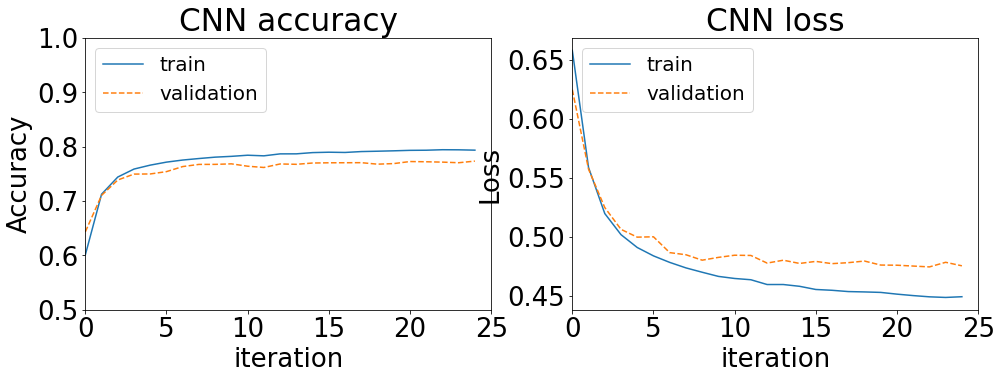

In [51]:
model.summary()
print_learning_history(history)

# print_learning_history(test_history)

In [ ]:
print('data_x_train ', data_x_train.shape)
print('data_x_test ',data_x_test.shape)
print('data_x_val', data_x_val.shape) 


print('data_y_train ',data_y_train.shape)
print('data_y_test ',data_y_test.shape)
print('data_y_val', data_y_val.shape)

weights = model.get_weights()
index = 0
print(model.layers[index])
print(weights[index])

In [1]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
# list all data in history
print(history.history.keys())
print('accuracy: ', history.history['accuracy'])
print('val_accuracy: ', history.history['val_accuracy'])
# summarize history for accuracy
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax1.set_ylim([0.5, 1])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [ ]:
# ## EEG2Code prediction

# for trial in range(data_x_test.shape[0]):
#     data_x_test_run = data_x_test[trial,:,:,:].squeeze()
#     data_y_test_run = data_y_test[trial,:].squeeze()
    
    
#     # do EEG2Code prediction (sample-wise)
#     preddata = model.predict(data_x_test_run.reshape(-1,data_x_test_run.shape[1],data_x_test_run.shape[2],1))
#     print(preddata[:20])
#     print(data_y_test_run[:20])
#     print(data_x_test_run[:20])
#     print(preddata.shape)
    
#     # transform model prediction to predicted stimulation pattern
#     predpattern = np.round(preddata)
    
# #     print(predpattern[trial])
#     # compare predicted stimulation pattern to real stimulation pattern
#     realpattern = np.round(data_y_test_run)
#     accuracy = np.mean(predpattern==realpattern)
# #     print (accuracy)

In [ ]:
# print(preddata.shape)

## LDA

In [ ]:
# fit LDA + Epoch classification
s_train, w_train, c_train, s = data_x_train.shape
Xtrain = data_x_train.reshape(s_train, w_train*c_train*s)

Ytrain = data_y_train[:,1]


s_test, w_test, c_test, s = data_x_test.shape

Xtest = data_x_test.reshape(s_test, w_test*c_test*s) 

Ytest = data_y_test[:,1]

print(Xtest.shape, Xtrain.shape)
print(Ytest.shape, Ytrain.shape)

clf = LDA()
clf.fit(Xtrain, Ytrain)
score = clf.score(Xtest, Ytest) * 100
print('LDA epoch accuracy: {:.2f}%'.format(score))

In [ ]:
# Trial classification LDA
trials = int(Xtest.shape[0]/sV.shape[0])
sample_epochs = int(Xtest.shape[0]/trials)



pred = clf.predict(Xtest)



# Predict Xtrain epochs. Take column 1 since that equals probabilities of 1 occuring
pred_proba = clf.predict_proba(Xtest)
p1 = pred_proba[:,1]


# Reshape predictions to trials x epochs
predicted_trials = p1.reshape(trials,sample_epochs)

#First index of labels for the test set
test_trials = X.shape[2]-trials


predictions = np.zeros(trials)
for i in range(trials):
    rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
    predictions[i]=np.argmax(rho)+1
    
pp = sum(predictions == y[test_trials:,0])
print('LDA trial accuracy: ', pp/trials*100)

print(predictions.astype(int))
print(y[test_trials:,0])

## NN

In [ ]:
# NN classify epochs

predict_proba_test = model.predict(data_x_test)
print(predict_proba_test)

In [ ]:
true_epochs = data_y_test[:,1]
pred_epochs = predict_proba_test[:,1]




correct = 0
for i in range(true_epochs.shape[0]):
    if (pred_epochs[i] >= 0.5) and (true_epochs[i]==1):
        correct+=1
    if (pred_epochs[i] < 0.5) and (true_epochs[i]==0):
        correct+=1
        
print('amount correct: ', correct, 'of' , true_epochs.shape[0])
print('NN epoch accuracy: ', correct / true_epochs.shape[0])

In [ ]:
# NN trial classification

trials = int(Xtest.shape[0]/sV.shape[0])
sample_epochs = int(Xtest.shape[0]/trials)

predicted_trials = pred_epochs.reshape(trials,sample_epochs)




predictions = np.zeros(trials)
for i in range(trials):
    rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
    predictions[i]=np.argmax(rho)+1


test_trials = X.shape[2]-trials   #index of the first test trial in y


print(predictions.astype(int))
print(y[test_trials:,0])

pp = sum(predictions == y[test_trials:,0])
print('amount of correct guesses', pp)
print('accuracy', pp/trials)

